<a href="https://colab.research.google.com/github/hzchzc123123/CTR/blob/main/AFM%E5%AE%9E%E6%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 43.1 MB/s eta 0:00:00


In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import itertools


import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Dict, Text
from ast import literal_eval
from torchkeras import summary,KerasModel

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 数据预处理

In [ ]:
dataset_dir = "/content/drive/MyDrive/CRT/Neural CF/NeuralCF/archive/"
credits = pd.read_csv(dataset_dir + 'credits.csv')
keywords = pd.read_csv(dataset_dir + 'keywords.csv')
movies = pd.read_csv(dataset_dir + 'movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)
df['release_date'] = pd.to_datetime(df['release_date'])

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)
df['label'] = (df['vote_average'] > 6.5).astype(int)
df['year_month'] = df['release_date'].dt.strftime('%Y-%m')
df['year_month'] = df['year_month'].astype('object')

df.drop('vote_average', axis=1, inplace=True)
df.drop('release_date', axis=1, inplace=True)
df.drop('cast', axis=1, inplace=True)
df.drop('original_title', axis=1, inplace=True)
df.drop('overview', axis=1, inplace=True)
df.drop('tagline', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [ ]:
df.head(3)

,adult,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_count,keywords,crew,characters,actors,label,year_month
0,False,30000000.0,"Animation, Comedy, Family",en,21.946943,Pixar Animation Studios,United States of America,373554033.0,81.0,English,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",1,1995-10
1,False,65000000.0,"Adventure, Fantasy, Family",en,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,262797249.0,104.0,"English, Français",2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",1,1995-12
2,False,0.0,"Romance, Comedy",en,11.712900,"Warner Bros., Lancaster Gate",United States of America,0.0,101.0,English,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",0,1995-12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45558 entries, 0 to 45557
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45558 non-null  object 
 1   budget                45558 non-null  float64
 2   genres                45558 non-null  object 
 3   original_language     45558 non-null  object 
 4   popularity            45558 non-null  float64
 5   production_companies  45558 non-null  object 
 6   production_countries  45558 non-null  object 
 7   revenue               45558 non-null  float64
 8   runtime               45558 non-null  float64
 9   spoken_languages      45558 non-null  object 
 10  vote_count            45558 non-null  float64
 11  keywords              45558 non-null  object 
 12  crew                  45558 non-null  object 
 13  characters            45558 non-null  object 
 14  actors                45558 non-null  object 
 15  label              

In [ ]:
label = df['label']
df.drop('label', axis=1, inplace=True)

In [ ]:
continuous_counter = 1
categorical_counter = 1
new_columns = []

# 遍历每一列
for col, dtype in df.dtypes.iteritems():
    if dtype == 'float64':
        new_columns.append(f'I{continuous_counter}')
        continuous_counter += 1
    elif dtype == 'object':
        new_columns.append(f'C{categorical_counter}')
        categorical_counter += 1
    else:  # 如果还有其他数据类型，保留原始名称
        new_columns.append(col)

df.columns = new_columns

In [ ]:
df.head()

,C1,I1,C2,C3,I2,C4,C5,I3,I4,C6,I5,C7,C8,C9,C10,C11
0,False,30000000.0,"Animation, Comedy, Family",en,21.946943,Pixar Animation Studios,United States of America,373554033.0,81.0,English,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",1995-10
1,False,65000000.0,"Adventure, Fantasy, Family",en,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,262797249.0,104.0,"English, Français",2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",1995-12
2,False,0.0,"Romance, Comedy",en,11.712900,"Warner Bros., Lancaster Gate",United States of America,0.0,101.0,English,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",1995-12
3,False,16000000.0,"Comedy, Drama, Romance",en,3.859495,Twentieth Century Fox Film Corporation,United States of America,81452156.0,127.0,English,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin...",1995-12
4,False,0.0,Comedy,en,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,76578911.0,106.0,English,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb...",1995-02


In [ ]:
def sparsFeature(feat, feat_num, embed_dim=4):
    """
    create dictionary for sparse feature
    :param feat: feature_name
    :param feat_num: the total number of sparse features that do not repeat
    :param embed_dim: embedding dimension
    :return
    """
    return {'feat': feat, 'feat_num': feat_num, 'embed_dim': embed_dim}

def denseFeature(feat):
    """
    create dictionary for dense feature
    :param feat: dense feature name
    : return
    """
    return {'feat': feat}

In [ ]:
sparse_feas = [col for col in df.columns if col[0] == 'C']
dense_feas = [col for col in df.columns if col[0] == 'I']
dense_feas

['I1', 'I2', 'I3', 'I4', 'I5']

In [ ]:
df[sparse_feas] = df[sparse_feas].fillna('-1')
df[dense_feas] = df[dense_feas].fillna(0)

In [ ]:
# 把特征列保存成字典, 方便类别特征的处理工作
def create_cretio_data(embed_dim=8, test_size=0.2):
    feature_columns = [[denseFeature(feat) for feat in dense_feas]] + [[sparsFeature(feat, len(df[feat].unique()), embed_dim=embed_dim) for feat in sparse_feas]]

    # 进行编码  类别特征编码
    for feat in sparse_feas:
      le = LabelEncoder()
      df[feat] = le.fit_transform(df[feat])
    # 数值特征归一化
    mms = MinMaxScaler()
    df[dense_feas] = mms.fit_transform(df[dense_feas])

    def sort_columns(column):
      match = re.match(r"([a-z]+)([0-9]+)", column, re.I)
      if match:
          parts = match.groups()
          # 字母部分降序，数字部分升序
          return -ord(parts[0].lower()), int(parts[1])
      return -ord(column.lower()), 0

  # 对列名进行排序,由于列名是字符串，不能直接sort
    sorted_columns = sorted(df.columns, key=sort_columns)

  # 根据排序后的列名重新组织DataFrame
    train = df[sorted_columns]
    train['Label'] = label
  # 划分验证集
    train_set, val_set = train_test_split(train, test_size = 0.2, random_state=2020)
    train_set.reset_index(drop=True, inplace=True)
    val_set.reset_index(drop=True, inplace=True)
    return train_set,val_set

In [ ]:
train,val = create_cretio_data()

In [ ]:
train

,I1,I2,I3,I4,I5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,Label
0,0.000000,0.000153,0.000000,0.069268,0.000497,0,1809,18,3386,2190,334,10292,14330,15269,32071,944,0
1,0.000000,0.003840,0.000000,0.144904,0.001066,0,2903,18,18665,2147,334,20366,9130,6365,27142,993,1
2,0.000000,0.001119,0.000000,0.082803,0.000284,0,1839,61,6756,1686,1258,18073,39183,787,20640,1326,0
3,0.131579,0.018808,0.047411,0.117038,0.085115,0,1712,18,5169,1876,334,17020,3982,17883,3715,1208,1
4,0.000000,0.001037,0.000000,0.000000,0.000000,0,1841,18,17462,2208,334,0,22159,264,35275,1155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36441,0.000000,0.011422,0.004676,0.074045,0.005400,0,1528,63,5427,2190,710,2723,14204,8166,25938,1105,0
36442,0.000000,0.006038,0.002000,0.115446,0.003197,0,2355,16,17944,396,1260,19166,435,22380,33418,1268,1
36443,0.000000,0.001945,0.000000,0.063694,0.000284,0,3288,25,4019,184,943,0,14998,74,12101,1328,0
36444,0.000000,0.000072,0.000000,0.080414,0.000071,0,0,18,0,2190,334,0,38487,907,35254,1197,0


In [ ]:
val

,I1,I2,I3,I4,I5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,Label
0,0.000000,0.004166,0.0,0.085191,0.000782,0,1968,18,5028,704,334,0,27810,31246,8983,1112,0
1,0.000000,0.000427,0.0,0.069268,0.000142,0,1528,18,12165,2190,334,6425,11882,5984,40907,381,1
2,0.000000,0.000024,0.0,0.039013,0.000284,0,1145,18,3587,2190,334,15431,9558,6062,22066,958,0
3,0.092105,0.033147,0.0,0.099522,0.003979,0,643,88,6743,472,1798,0,39534,6467,18533,1271,0
4,0.016519,0.012914,0.0,0.103503,0.003623,0,2258,66,1247,1736,1295,24192,12860,13955,32785,1332,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9107,0.000000,0.002507,0.0,0.069268,0.002060,0,1766,18,16049,978,334,0,27835,15583,1971,1236,1
9108,0.000000,0.010901,0.0,0.107484,0.005258,0,1528,18,18835,2190,334,17123,24614,27824,16023,689,1
9109,0.000000,0.000999,0.0,0.074841,0.000426,0,1222,18,9585,2190,444,1388,38520,5647,12834,463,0
9110,0.000000,0.002820,0.0,0.071656,0.000710,0,1839,18,2617,804,334,11105,36827,7688,15394,1136,0


## 开始Wide&Deep

In [ ]:
trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
val_x, val_y = val.drop(columns='Label').values, val['Label'].values


In [ ]:
sparse_feas_map = {}
for key in sparse_feas:
    sparse_feas_map[key] = df[key].nunique()
sparse_feas_map

{'C1': 2,
 'C2': 4045,
 'C3': 90,
 'C4': 22401,
 'C5': 2366,
 'C6': 1835,
 'C7': 25853,
 'C8': 42158,
 'C9': 39400,
 'C10': 41786,
 'C11': 1349}

In [ ]:
sparse_features = [
    {'feat': key, 'feat_num': value, 'embed_dim': 8}
    for key, value in sparse_feas_map.items()
]
sparse_features

[{'feat': 'C1', 'feat_num': 2, 'embed_dim': 8},
 {'feat': 'C2', 'feat_num': 4045, 'embed_dim': 8},
 {'feat': 'C3', 'feat_num': 90, 'embed_dim': 8},
 {'feat': 'C4', 'feat_num': 22401, 'embed_dim': 8},
 {'feat': 'C5', 'feat_num': 2366, 'embed_dim': 8},
 {'feat': 'C6', 'feat_num': 1835, 'embed_dim': 8},
 {'feat': 'C7', 'feat_num': 25853, 'embed_dim': 8},
 {'feat': 'C8', 'feat_num': 42158, 'embed_dim': 8},
 {'feat': 'C9', 'feat_num': 39400, 'embed_dim': 8},
 {'feat': 'C10', 'feat_num': 41786, 'embed_dim': 8},
 {'feat': 'C11', 'feat_num': 1349, 'embed_dim': 8}]

In [ ]:
dense_features = [{'feat': f'I{i}'} for i in range(1, 6)]
dense_features

[{'feat': 'I1'},
 {'feat': 'I2'},
 {'feat': 'I3'},
 {'feat': 'I4'},
 {'feat': 'I5'}]

In [ ]:
fea_cols = np.array([dense_features, sparse_features], dtype=object)
fea_cols

array([list([{'feat': 'I1'}, {'feat': 'I2'}, {'feat': 'I3'}, {'feat': 'I4'}, {'feat': 'I5'}]),
       list([{'feat': 'C1', 'feat_num': 2, 'embed_dim': 8}, {'feat': 'C2', 'feat_num': 4045, 'embed_dim': 8}, {'feat': 'C3', 'feat_num': 90, 'embed_dim': 8}, {'feat': 'C4', 'feat_num': 22401, 'embed_dim': 8}, {'feat': 'C5', 'feat_num': 2366, 'embed_dim': 8}, {'feat': 'C6', 'feat_num': 1835, 'embed_dim': 8}, {'feat': 'C7', 'feat_num': 25853, 'embed_dim': 8}, {'feat': 'C8', 'feat_num': 42158, 'embed_dim': 8}, {'feat': 'C9', 'feat_num': 39400, 'embed_dim': 8}, {'feat': 'C10', 'feat_num': 41786, 'embed_dim': 8}, {'feat': 'C11', 'feat_num': 1349, 'embed_dim': 8}])],
      dtype=object)

In [ ]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [ ]:
# 看一下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

torch.Size([32, 16]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])


## 构建模型

In [ ]:
class Dnn(nn.Module):
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout = 0.
        """
        super(Dnn, self).__init__()

        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        x = self.dropout(x)
        return x


In [ ]:
dense_feature_cols, sparse_feature_cols = fea_cols
hidden_units1 = [256, 128, 64]
hidden_units1.insert(0, len(dense_feature_cols) + len(sparse_feature_cols)*sparse_feature_cols[0]['embed_dim'])
hidden_units1
#在0处重新插入输入层，这和PNN不一，PNN输入层

[93, 256, 128, 64]

In [ ]:
class Attention_layer(nn.Module):
    def __init__(self, att_units):
        """
        :param att_units: [embed_dim, att_vector]#att_vectorMLP的隐藏层维度
        """
        super(Attention_layer, self).__init__()

        self.att_w = nn.Linear(att_units[0], att_units[1])
        self.att_dense = nn.Linear(att_units[1], 1)

    def forward(self, bi_interaction):     # bi_interaction (None, field_num*(field_num-1)_/2, embed_dim)
        a = self.att_w(bi_interaction)    # (None, field_num*(field_num-1)_/2, t) t为att_vector
        a = F.relu(a)             # (None, field_num*(field_num-1)_/2, t)
        att_scores = self.att_dense(a)  # (None, field_num*(field_num-1)_/2, 1)
        att_weight = F.softmax(att_scores, dim=1)  #  (None, field_num*(field_num-1)_/2, 1)

        att_out = torch.sum(att_weight * bi_interaction, dim=1)   # (None, embed_dim)
        return att_out

In [ ]:
class AFM(nn.Module):
    def __init__(self, feature_columns, mode, hidden_units, att_vector=8, dropout=0.5, useDNN=False):
        """
        AFM:
        :param feature_columns: 特征信息， 这个传入的是fea_cols array[0] dense_info  array[1] sparse_info
        :param mode: A string, 三种模式, 'max': max pooling, 'avg': average pooling 'att', Attention
        :param att_vector: 注意力网络的隐藏层单元个数
        :param hidden_units: DNN网络的隐藏单元个数， 一个列表的形式， 列表的长度代表层数， 每个元素代表每一层神经元个数， lambda文里面没加
        :param dropout: Dropout比率
        :param useDNN: 默认不使用DNN网络
        """
        super(AFM, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        self.mode = mode
        self.useDNN = useDNN

        # embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })

        # 如果是注意机制的话，这里需要加一个注意力网络
        if self.mode == 'att':
            self.attention = Attention_layer([self.sparse_feature_cols[0]['embed_dim'], att_vector])

        # 如果使用DNN的话， 这里需要初始化DNN网络
        if self.useDNN:
            # 这里要注意Pytorch的linear和tf的dense的不同之处， 前者的linear需要输入特征和输出特征维度， 而传入的hidden_units的第一个是第一层隐藏的神经单元个数，这里需要加个输入维度
            self.fea_num = len(self.dense_feature_cols) + self.sparse_feature_cols[0]['embed_dim']
            hidden_units.insert(0, self.fea_num)

            self.bn = nn.BatchNorm1d(self.fea_num)
            self.dnn_network = Dnn(hidden_units, dropout)
            self.nn_final_linear = nn.Linear(hidden_units[-1], 1)
        else:
            self.fea_num = len(self.dense_feature_cols) + self.sparse_feature_cols[0]['embed_dim']
            self.nn_final_linear = nn.Linear(self.fea_num, 1)

    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()       # 转成long类型才能作为nn.embedding的输入
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.stack(sparse_embeds)     # embedding堆起来， (field_dim, None, embed_dim)
        sparse_embeds = sparse_embeds.permute((1, 0, 2))
        # 这里得到embedding向量之后 sparse_embeds(None, field_num, embed_dim)
        # 下面进行两两交叉， 注意这时候不能加和了，也就是NFM的那个计算公式不能用， 这里两两交叉的结果要进入Attention
        # 两两交叉enbedding之后的结果是一个(None, (field_num*field_num-1)/2, embed_dim)
        # 这里实现的时候采用一个技巧就是组合
        #比如fild_num有4个的话，那么组合embeding就是[0,1] [0,2],[0,3],[1,2],[1,3],[2,3]位置的embedding乘积操作
        # 初始化两个列表来存放将要两两交叉的特征索引
        first = []
        second = []

        # 通过itertools.combinations生成所有可能的特征对索引
        # range(sparse_embeds.shape[1]) 产生一个范围，这个范围是嵌入向量的特征数
        # itertools.combinations 接受这个范围并且生成所有特征对的组合
        for f, s in itertools.combinations(range(sparse_embeds.shape[1]), 2):#生成所有的二元索引组合
            first.append(f)  # 把第一个特征的索引加入到 first 列表
            second.append(s) # 把第二个特征的索引加入到 second 列表

        # first 和 second 存储了所有特征对的索引，用于后续提取相应的嵌入向量进行交叉

        # 提取对应于 first 中索引的嵌入向量，这会生成交叉特征对中第一个特征的嵌入表示
        p = sparse_embeds[:, first, :]  # (batch_size, (field_num*(field_num-1)_/2, embed_dim)

        # 提取对应于 second 中索引的嵌入向量，这会生成交叉特征对中第二个特征的嵌入表示
        q = sparse_embeds[:, second, :] # (batch_size, (field_num*(field_num-1)_/2, embed_dim)

        # 对每一对特征对的嵌入向量进行逐元素乘法，得到交叉特征向量
        bi_interaction = p * q  # (batch_size, (field_num*(field_num-1)_/2, embed_dim)

        if self.mode == 'max':
            att_out = torch.sum(bi_interaction, dim=1)  #  (None, embed_dim)
        elif self.mode == 'avg':
            att_out = torch.mean(bi_interaction, dim=1)  # (None, embed_dim)
        else:
            # 注意力网络
            att_out = self.attention(bi_interaction)  # (None, embed_dim)

        # 把离散特征和连续特征进行拼接
        x = torch.cat([att_out, dense_inputs], dim=-1)

        if not self.useDNN:
            outputs = F.sigmoid(self.nn_final_linear(x))
        else:
            # BatchNormalization
            x = self.bn(x)
            # deep
            dnn_outputs = self.nn_final_linear(self.dnn_network(x))
            outputs = F.sigmoid(dnn_outputs)

        return outputs

In [ ]:
# 建立模型
hidden_units = [128, 64, 32]
dnn_dropout = 0.

model = AFM(fea_cols, 'att', hidden_units, dropout=dnn_dropout, useDNN=True)
summary(model, input_shape=(trn_x.shape[1],))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                  [-1, 8]                   16
Embedding-2                                  [-1, 8]               32,360
Embedding-3                                  [-1, 8]                  720
Embedding-4                                  [-1, 8]              179,208
Embedding-5                                  [-1, 8]               18,928
Embedding-6                                  [-1, 8]               14,680
Embedding-7                                  [-1, 8]              206,824
Embedding-8                                  [-1, 8]              337,264
Embedding-9                                  [-1, 8]              315,200
Embedding-10                                 [-1, 8]              334,288
Embedding-11                                 [-1, 8]               10,792
Linear-12                            

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                  [-1, 8]                   16\nEmbedding-2                                  [-1, 8]               32,360\nEmbedding-3                                  [-1, 8]                  720\nEmbedding-4                                  [-1, 8]              179,208\nEmbedding-5                                  [-1, 8]               18,928\nEmbedding-6                                  [-1, 8]               14,680\nEmbedding-7                                  [-1, 8]              206,824\nEmbedding-8                                  [-1, 8]              337,264\nEmbedding-9                                  [-1, 8]              315,200\nEmbedding-10                                 [-1, 8]              334,288\nEmbedding-11          

In [ ]:
# 测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.5423],
        [0.5313],
        [0.5436],
        [0.5201],
        [0.5254],
        [0.5309],
        [0.5428],
        [0.5315],
        [0.5350],
        [0.5373],
        [0.5291],
        [0.5320],
        [0.5361],
        [0.5446],
        [0.5295],
        [0.5438],
        [0.5140],
        [0.5073],
        [0.5360],
        [0.5224],
        [0.5277],
        [0.5295],
        [0.5208],
        [0.5356],
        [0.5378],
        [0.5288],
        [0.5346],
        [0.5247],
        [0.5322],
        [0.5159],
        [0.5081],
        [0.5167]], grad_fn=<SigmoidBackward0>)


## 模型的训练

In [ ]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

#按照理论来说wide部分用的是L1正则，用FTRL优化器，而deep部分用普通L2正则，但这边都从简了
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)#正则项系数别忘了搞，不然训出来一坨狗屎
metric_func = auc
metric_name = 'auc'

In [ ]:
# 脚本训练风格
epochs = 8
log_step_freq = 100
patience = 2
best_val_loss = float('inf')
patience_counter = 0

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):

    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播
        predictions = model(features)
        predictions = predictions.squeeze()
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass

        # 反向传播
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));

    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            predictions = predictions.squeeze()
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
        val_loss = val_loss_sum/val_step
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 重置计数器
    else:
        patience_counter += 1  # 增加计数器

    # 检查是否达到早停条件
    if patience_counter >= patience:
        print("Stopping early due to increasing val loss!")
        break

    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)

print('Finished Training')

start_training.........
================================================================2023-11-13 11:28:08
[step=100] loss: 0.631, auc: 0.521
[step=200] loss: 0.625, auc: 0.562
[step=300] loss: 0.624, auc: 0.565
[step=400] loss: 0.620, auc: 0.576
[step=500] loss: 0.618, auc: 0.584
[step=600] loss: 0.616, auc: 0.591
[step=700] loss: 0.616, auc: 0.598
[step=800] loss: 0.614, auc: 0.603
[step=900] loss: 0.613, auc: 0.607
[step=1000] loss: 0.611, auc: 0.611
[step=1100] loss: 0.610, auc: 0.613

EPOCH=1, loss=0.609, auc = 0.615, val_loss=0.596, val_auc = 0.648

================================================================================2023-11-13 11:28:26
[step=100] loss: 0.585, auc: 0.646
[step=200] loss: 0.591, auc: 0.651
[step=300] loss: 0.588, auc: 0.650
[step=400] loss: 0.588, auc: 0.655
[step=500] loss: 0.588, auc: 0.659
[step=600] loss: 0.589, auc: 0.659
[step=700] loss: 0.589, auc: 0.661
[step=800] loss: 0.590, auc: 0.663
[step=900] loss: 0.591, auc: 0.663
[step=1000] loss: 0.59

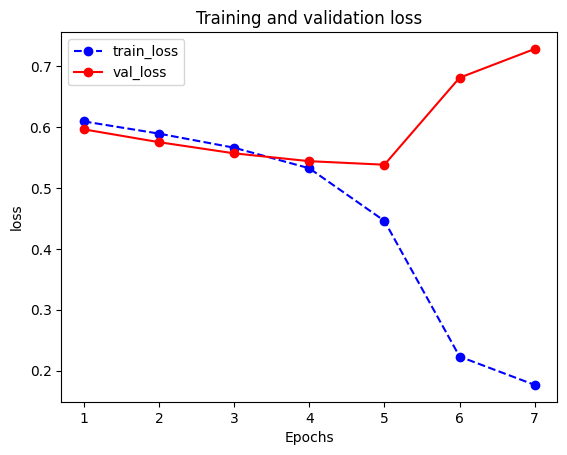

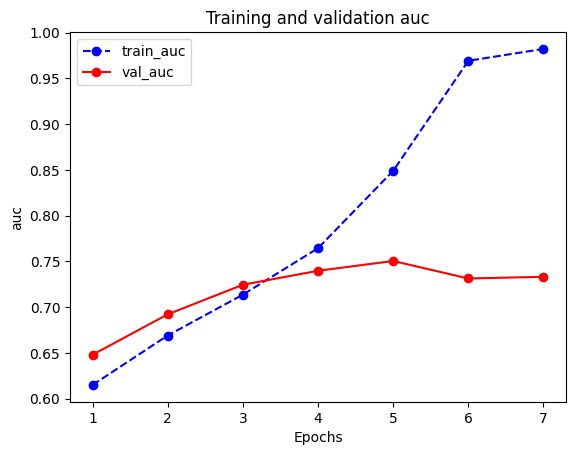

In [ ]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")
#过拟合过到离谱